In [1]:
"""A Cox process model for spatial analysis
(Cox, 1955; Miller et al., 2014).
The data set is a N x V matrix. There are N NBA players, X =
{(x_1, ..., x_N)}, where each x_n has a set of V counts. x_{n, v} is
the number of attempted basketball shots for the nth NBA player at
location v.
We model a latent intensity function for each data point. Let K be the
N x V x V covariance matrix applied to the data set X with fixed
kernel hyperparameters, where a slice K_n is the V x V covariance
matrix over counts for a data point x_n.
For n = 1, ..., N,
  p(f_n) = N(f_n | 0, K_n),
  p(x_n | f_n) = \prod_{v=1}^V p(x_{n,v} | f_{n,v}),
    where p(x_{n,v} | f_{n, v}) = Poisson(x_{n,v} | exp(f_{n,v})).
"""

# cox process is one of poission process latent variable model that enlighen our model
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import edward as ed
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from edward.models import MultivariateNormalTriL, Normal, Poisson
from edward.util import rbf
from scipy.stats import multivariate_normal, poisson
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [2]:
def build_toy_dataset(N, V):
    """A simulator mimicking the data set from 2015-2016 NBA season with
    308 NBA players and ~150,000 shots."""
    L = np.tril(np.random.normal(2.5, 0.1, size=[V, V]))
    K = np.matmul(L, L.T)
    x = np.zeros([N, V])
    for n in range(N):
        f_n = multivariate_normal.rvs(cov=K, size=1)
        for v in range(V):
            x[n, v] = poisson.rvs(mu=np.exp(f_n[v]), size=1)

    return x

In [3]:
ed.set_seed(42)

N = 50  # number of NBA players
V = 2  # number of shot locations

# DATA
x_data = build_toy_dataset(N, V)

# MODEL
x_ph = tf.placeholder(tf.float32, [N, V])  # inputs to Gaussian Process

# Form (N, V, V) covariance, one matrix per data point.
K = tf.stack([rbf(tf.reshape(xn, [V, 1])) + tf.diag([1e-6, 1e-6])
              for xn in tf.unstack(x_ph)])
f = MultivariateNormalTriL(loc=tf.zeros([N, V]), scale_tril=tf.cholesky(K))
x = Poisson(rate=tf.exp(f))

# INFERENCE
qf = Normal(loc=tf.Variable(tf.random_normal([N, V])),
            scale=tf.nn.softplus(tf.Variable(tf.random_normal([N, V]))))

inference = ed.KLqp({f: qf}, data={x: x_data, x_ph: x_data})
inference.run(n_iter=5000)

/home/roger/anaconda3/envs/tensorflow1_5/lib/python3.6/site-packages/edward/util/random_variables.py:52: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  not np.issubdtype(value.dtype, np.float) and \


5000/5000 [100%] ██████████████████████████████ Elapsed: 8s | Loss: 4693.404


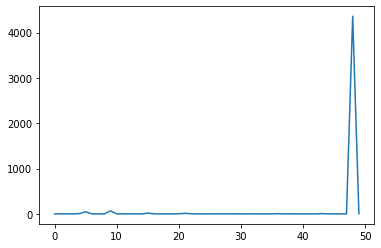

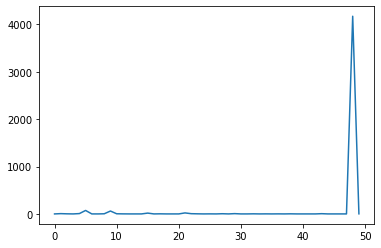

In [4]:
# Evaluate
x_post = ed.copy(x, {f: qf})
x_post1 = x_post.eval()
plt.plot(x_post1[:,0])
plt.figure()
plt.plot(x_data[:,0])
plt.show()